In [1]:
"""
The aim of this notebook is to find the calbration curve of
a set of regression models. One problem we've faced is the 
size of the data we are working with. The current shape of
the CSV file is about 6800 x 95, which makes it hard to train
all the data we are working with. 
"""
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [2]:
# Prep the data
df = pd.read_csv('data.csv')

# Function removes outlier more than 1.5 std from 25th and 75 percentile
def remove_outlier(feature, feature_name, dataset):
    p25, p75 = np.percentile(feature, 25), np.percentile(feature,75)
    feat_iqr = p75 - p25
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = p25 - feat_cut_off, p75 + feat_cut_off
    outliers = [x for x in feature if x < feat_lower or x> feat_upper]
    dataset = dataset.drop(dataset[(dataset[feature_name]>feat_upper)|(dataset[feature_name]<feat_lower)].index)
    return dataset

# remove outlier
for col in df:
    new_df = remove_outlier(df[col], str(col), df)
    
X = new_df.drop(['Bankrupt?'], axis=1)
y = new_df['Bankrupt?']

# Oversampling to combat unabalanced data
oversample = SMOTE()
X,y=oversample.fit_resample(X,y)
#sns.countplot(x=y)



x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# We are training at 30% right now, might adjust that in a bit

x_train.shape

(8472, 95)

In [3]:
# Build a logistic regression model
log_model = LogisticRegression(max_iter=1_000_000_000).fit(x_train, y_train)

log_predictions = log_model.score(x_test, y_test)
print("Test accuracy: {:.4f}".format(log_predictions*100))

Test accuracy: 59.1960


In [4]:
# Build a SVC model
svc_model = SVC(max_iter=1_000_000_000).fit(x_train, y_train)

svc_predictions = svc_model.score(x_test, y_test)
print("Test accuracy: {:.4f}".format(svc_predictions*100))

Test accuracy: 79.8458


In [5]:
# Build a Random Forest Classifier
rfc_model = RandomForestClassifier().fit(x_train, y_train)

rfc_predictions = rfc_model.score(x_test, y_test)
print("Test accuracy: {:.4f}".format(rfc_predictions*100))

Test accuracy: 97.5771


In [6]:
# Decision tree classifier 🤔 
dtc_model = DecisionTreeClassifier().fit(x_train, y_train)

dtc_predictions = dtc_model.score(x_test, y_test)
print("Test accuracy: {:.4f}".format(dtc_predictions*100))

Test accuracy: 94.8238


In [7]:
# K Nearest Neighbor Classifier
knn_model = KNeighborsClassifier().fit(x_train, y_train)

knn_predictions = knn_model.score(x_test, y_test)
print("Test accuracy: {:.4f}".format(knn_predictions*100))

Test accuracy: 90.5562


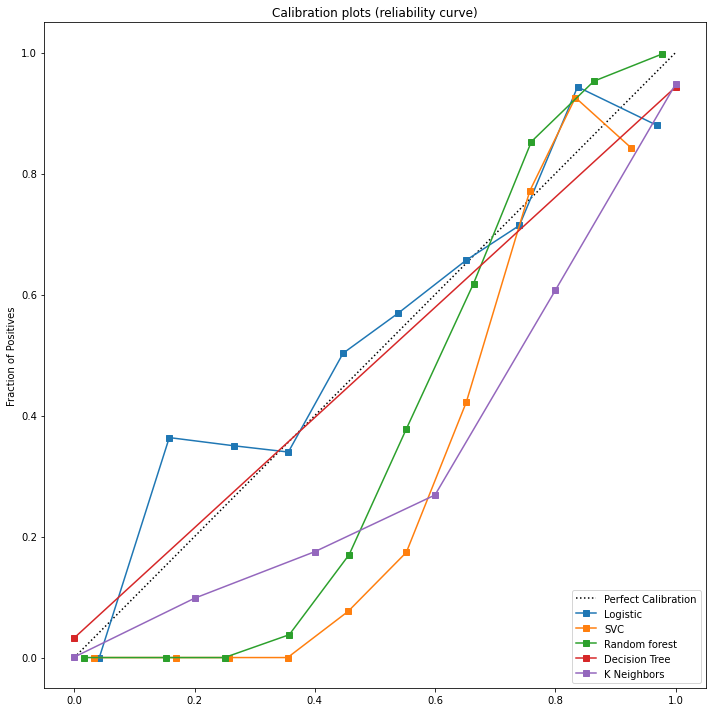

In [8]:
models = [(log_model, 'Logistic'), (svc_model, 'SVC'), (rfc_model, "Random forest"), (dtc_model, "Decision Tree"), (knn_model, "K Neighbors")]

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot()

ax.plot([0, 1], [0, 1], "k:", label='Perfect Calibration')
for model, name in models:
    model.fit(x_train, y_train)
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(x_test)[:, 1]
    else:
        prob_pos = model.decision_function(x_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
        
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))

ax.set_ylabel("Fraction of Positives")
ax.set_ylim([-0.05, 1.05])
ax.legend(loc='lower right')
ax.set_title("Calibration plots (reliability curve)")

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

<AxesSubplot:>

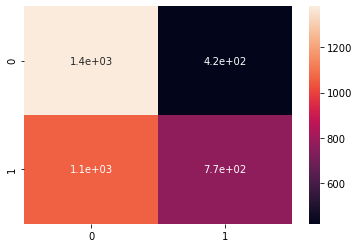

In [10]:
y_pred=log_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

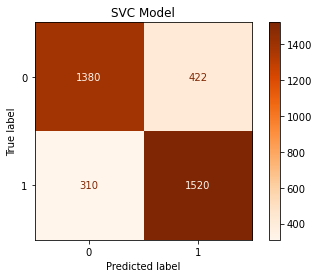

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

disp = plot_confusion_matrix(svc_model, x_test, y_test, cmap=plt.cm.Oranges)
disp.ax_.set_title("SVC Model")

plt.show()

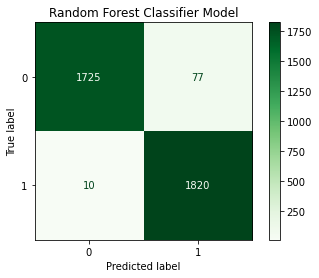

In [27]:
disp = plot_confusion_matrix(rfc_model, x_test, y_test, cmap=plt.cm.Greens)
disp.ax_.set_title("Random Forest Classifier Model")

plt.show()

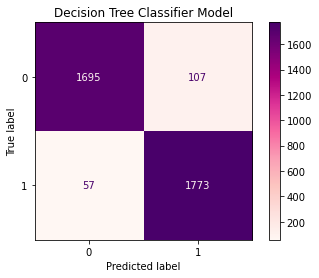

In [29]:
disp = plot_confusion_matrix(dtc_model, x_test, y_test, cmap=plt.cm.RdPu)
disp.ax_.set_title("Decision Tree Classifier Model")

plt.show()

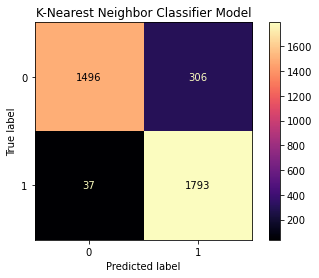

In [33]:
disp = plot_confusion_matrix(knn_model, x_test, y_test, cmap=plt.cm.magma)
disp.ax_.set_title("K-Nearest Neighbor Classifier Model")

plt.show()

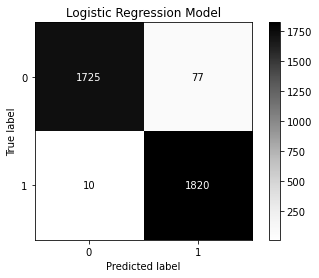

In [38]:
disp = plot_confusion_matrix(rfc_model, x_test, y_test, cmap=plt.cm.Greys)
disp.ax_.set_title("Logistic Regression Model")

plt.show()